In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import ipywidgets
from ipywidgets import interact, interact_manual

from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

# Calculate the Binary LGE hit or miss ratios
Between LGE Segments and Segments defined by Circle or Tarique

## Column: 'Tarique abnormal'

bullsplot used here
tarique, bullsplot, motion curves
11 - mid inferolateral 

first: quality check: single segments only is very rare, two segments are better/more often that means more plausible. Not just the septum is affected. If all segments are affected, tracking may be wrong. 
second: based on experience, 11 and 12 AHA are mostly affected. Check also on circumferential and radial strain values, are they low? Bullseye plot is used for help.

## Column: 'Strain diff' 

Bezieht sich auf die orginal column: 'Segment from strain if different'

- tarique says this is difference between D and F
- tarique says this column is not helpful
- tarique says this columns relates to if different from LGE

He also said that this column shows the additional segments when he applies the Strain thresholding



# Define some helper functions

In [2]:

def cross_validate_f1(x,y):
    import matplotlib.pyplot as plt
    plt.rcParams.update({'font.size': 16})
    
    clf1 = LogisticRegression(random_state=1, class_weight='balanced')
    clf2 = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500, random_state=1, class_weight='balanced')) #RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
    clf3 = GaussianNB()
    clf4 = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier(class_weight='balanced'))
    clf5 = make_pipeline(StandardScaler(), NeighborhoodComponentsAnalysis(random_state=42, n_components=2), KNeighborsClassifier(n_neighbors=2))
    clf6 = make_pipeline(StandardScaler(), SVC(kernel='poly',gamma='auto',class_weight='balanced', C=1, degree=3))
    clf7 = SVC(kernel='poly', gamma='auto',class_weight='balanced')
    # ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
    # NeighborhoodComponentsAnalysis(n_components=10, random_state=random_state),
    
    eclf = VotingClassifier(
        estimators=[
            #('lr', clf1), 
             
            ('lr', clf1), 
            ('rf', clf2), ('svc', clf6),
            ('svc2', clf7)
                   ],
        voting='hard')
    
    fig, ax = plt.subplots(1,8, figsize=(25,5))
    i = 0
    for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'scaled DecissionTree', 'KNN', 'scaled SVC(poly)', 'SVC(poly)', 'Ensemble']):
        y_pred = cross_val_predict(clf, x, y, cv=5)
        scores = cross_validate(clf, x, y, scoring=['recall', 'accuracy'], cv=5)
        print('*'*10,label,'*'*10)
        print(scores['test_recall'])
        print("Recall: %0.2f (+/- %0.2f) [%s]" % (scores['test_recall'].mean(), scores['test_recall'].std(), label))
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std(), label))
        ConfusionMatrixDisplay.from_predictions(y, y_pred, labels=[1,0],ax=ax[i], colorbar=False)
        ax[i].set_title(label)
        ax[i].xaxis.label.set_visible(False)
        ax[i].yaxis.label.set_visible(False)
        i = i + 1
    plt.show()

# Read the dmd dataframe with all timesteps

In [3]:
from ipyfilechooser import FileChooser
import os
path_chooser = FileChooser(os.path.join(os.getcwd(),'/mnt/sds/sd20i001/'), '')
display(path_chooser)

FileChooser(path='/mnt/sds/sd20i001', filename='', title='HTML(value='', layout=Layout(display='none'))', show…

In [4]:
#/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/p2p/dmd/v4/register_backwards_compose_v2/img1_msk0_reg0_01_v2
#df_strain_comp = pd.read_csv('/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/p2p/dmd/v4/register_backwards_compose_v2/img1_msk0_reg0_01_v2/df_DMD_time_ed2p.csv')
#df_strain_p2p = pd.read_csv('/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/p2p/dmd/v4/register_backwards_compose_v2/img1_msk0_reg0_01_v2/df_DMD_time_p2p.csv')
df_strain_comp = pd.read_csv(os.path.join(path_chooser.selected, 'df_DMD_time_ed2p.csv'))
df_strain_p2p = pd.read_csv(os.path.join(path_chooser.selected,'df_DMD_time_p2p.csv'))
df_strain_comp.sort_values(by=['pat', 'aha'], inplace=True)
df_strain_p2p.sort_values(by=['pat', 'aha'], inplace=True)
print(df_strain_comp[df_strain_comp.isna().any(axis=1)])
print(df_strain_p2p[df_strain_p2p.isna().any(axis=1)])
print(df_strain_comp.shape)
print(df_strain_p2p.shape)
df_strain_comp.head()

Empty DataFrame
Columns: [pat, aha, phase, our_rs, our_cs, soa, lge]
Index: []
Empty DataFrame
Columns: [pat, aha, phase, our_rs, our_cs, soa, lge]
Index: []
(4480, 7)
(4480, 7)


,pat,aha,phase,our_rs,our_cs,soa,lge
0,aa_20180710,1,0,0.915333,0.177148,0.0,0.0
1,aa_20180710,1,1,0.930618,0.226990,0.0,0.0
2,aa_20180710,1,2,0.596300,0.108193,0.0,0.0
3,aa_20180710,1,3,0.220566,0.043842,0.0,0.0
4,aa_20180710,1,4,0.005196,-0.000394,0.0,0.0


In [34]:
# Calc the mean/std for the phase2phases strain per patient, export as xlsx
temp = df_strain_p2p.groupby(['aha','phase']).mean()
temp.columns = map(lambda x : x + '_mean', temp.columns)
temp2 = df_strain_p2p.groupby(['aha','phase']).std()
temp2.columns = map(lambda x : x + '_std', temp2.columns)
temp = pd.concat([temp,temp2], axis=1)
temp.to_excel(os.path.join(path_chooser.selected, 'df_strain_p2p_mean.xlsx'))

In [36]:
# Calc the mean/std for the composed strain per patient, export as xlsx
temp = df_strain_comp.groupby(['aha','phase']).mean()
temp.columns = map(lambda x : x + '_mean', temp.columns)
temp2 = df_strain_comp.groupby(['aha','phase']).std()
temp2.columns = map(lambda x : x + '_std', temp2.columns)
temp = pd.concat([temp,temp2], axis=1)
temp.to_excel(os.path.join(path_chooser.selected, 'df_strain_comp_mean.xlsx'))

In [37]:
temp

our_rs_mean  our_cs_mean  soa_mean  lge_mean  our_rs_std  \
aha phase                                                             
1   0         0.879806     0.089290  0.035714  0.017857    0.398987   
    1         1.075437     0.148970  0.035714  0.017857    0.605217   
    2         0.658606     0.071887  0.035714  0.017857    0.321721   
    3         0.111531     0.001926  0.035714  0.017857    0.081021   
    4         0.003178     0.004315  0.035714  0.017857    0.009424   
...                ...          ...       ...       ...         ...   
16  0         0.272984     0.000857  0.071429  0.232143    0.181541   
    1         0.709379    -0.005076  0.071429  0.232143    0.257008   
    2         0.287029    -0.015934  0.071429  0.232143    0.230191   
    3         0.018638    -0.003388  0.071429  0.232143    0.015524   
    4        -0.004293     0.005913  0.071429  0.232143    0.008082   

           our_cs_std   soa_std   lge_std  
aha phase                                  
1   0        0.068014  0.187256  0.133631  
    1        0.093149  0.187256  0.133631  
    2        0.048374  0.187256  0.133631  
    3        0.012156  0.187256  0.133631  
    4        0.006549  0.187256  0.133631  
...               ...       ...       ...  
16  0        0.032843  0.259870  0.426021  
    1        0.040408  0.259870  0.426021  
    2        0.030687  0.259870  0.426021  
    3        0.005383  0.259870  0.426021  
    4        0.012554  0.259870  0.426021  

[80 rows x 8 columns]

In [5]:
#df_strain_comp.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
#df_strain_p2p.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [6]:
#df_strain_comp = df_strain_comp[~df_strain_comp['pat'].isin(['wc_20181015'])]
#df_strain_p2p = df_strain_p2p[~df_strain_p2p['pat'].isin(['wc_20181015'])]

# Violinplots of RS/CS per phase grouped by binary lge

******************** strain composed ********************


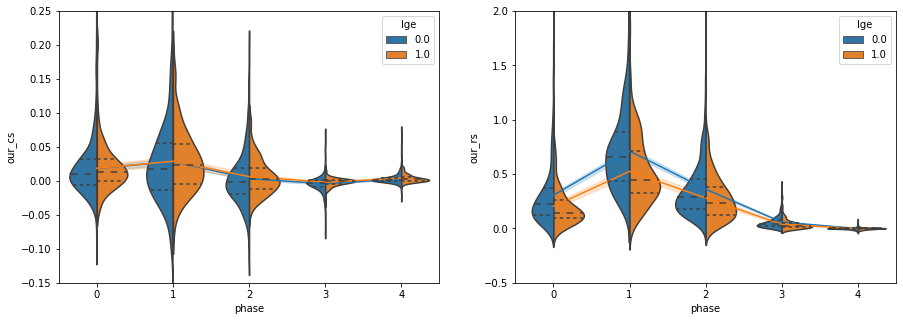

******************** strain p2p ********************


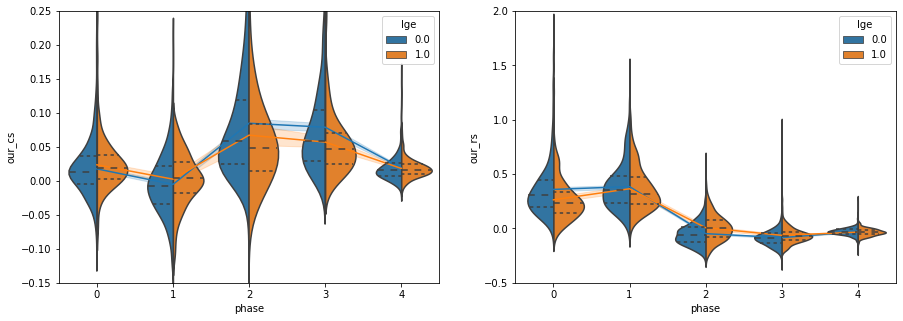

In [7]:
def plot_strain_per_time(df):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax1, ax2 = ax
    ax1 = sb.lineplot(x="phase", y="our_cs",
                 hue="lge",err_style='band', legend=False,ax=ax1,
                 data=df)
    ax1 = sb.violinplot(x="phase", y="our_cs",inner='quart',
                   ax=ax1,
                 data=df, split=True,hue='lge')
    ax1.set_ylim((-0.15, 0.25))
    

    ax2 = sb.lineplot(x="phase", y="our_rs",
                 hue="lge",err_style='band', legend=False,ax=ax2,
                 data=df)
    ax2 = sb.violinplot(x="phase", y="our_rs",inner='quart',
                   ax=ax2,
                 data=df, split=True,hue='lge')

    ax2.set_ylim((-0.5, 2.))
    plt.show()
    
print('*'*20,'strain composed','*'*20)
plot_strain_per_time(df_strain_comp)
print('*'*20,'strain p2p','*'*20)
plot_strain_per_time(df_strain_p2p)

# Identify pcs und prs 
- by max/min or by 
- a pre-defined phase (eg.: ES)

In [8]:
def get_peak_rs_cs(df, per_phase=True):
    
    if per_phase:
        # by phase
        pcs = df[df['phase']==1]['our_cs'].values
        prs = df[df['phase']==1]['our_rs'].values
        
    else:
        # get the peak radial and circumferential strains from all time steps
        # min/max
        pcs = np.stack(df_strain_comp.groupby(['phase'])['our_cs'].apply(list).values).astype(np.float32)
        pcs = pcs.min(axis=0)
        prs = np.stack(df_strain_comp.groupby(['phase'])['our_rs'].apply(list).values).astype(np.float32)
        prs = prs.max(axis=0)
        
    return prs, pcs

# peak radial and circumferential strain
# for the composed and p2p strain values
prs_com_p, pcs_com_p = get_peak_rs_cs(df_strain_comp, per_phase=True)
prs_com_arg, pcs_com_arg = get_peak_rs_cs(df_strain_comp, per_phase=False)
prs_p2p_p, pcs_p2p_p = get_peak_rs_cs(df_strain_p2p, per_phase=True)
prs_p2p_arg, pcs_p2p_arg = get_peak_rs_cs(df_strain_p2p, per_phase=False)
    
# 56 patients x 16 segments = 896 --> Peak strain per patient and segment
df_peak = df_strain_comp[df_strain_comp['phase']==0].copy()

# composed phase
df_peak['prs_com_p']=prs_com_p
df_peak['pcs_com_p']=pcs_com_p
# composed arg-min/max
df_peak['prs_com_arg']=prs_com_arg
df_peak['pcs_com_arg']=pcs_com_arg
# p2p phase
df_peak['prs_p2p_p']=prs_p2p_p
df_peak['pcs_p2p_p']=pcs_p2p_p
# p2p arg-min/max
df_peak['prs_p2p_arg']=prs_p2p_arg
df_peak['pcs_p2p_arg']=pcs_p2p_arg
# minor cleaning and dtype casting
df_peak.drop(labels='phase', axis=1, inplace=True)
df_peak.drop(labels='our_rs', axis=1, inplace=True)
df_peak.drop(labels='our_cs', axis=1, inplace=True)
df_peak.sort_values(by=['pat', 'aha'], inplace=True)
df_peak = df_peak.apply(lambda x: x.astype(np.float32, errors='ignore'), axis=0)
print(df_peak.dtypes)
print(df_peak.shape)

df_peak.head()

pat             object
aha            float32
soa            float32
lge            float32
prs_com_p      float32
pcs_com_p      float32
prs_com_arg    float32
pcs_com_arg    float32
prs_p2p_p      float32
pcs_p2p_p      float32
prs_p2p_arg    float32
pcs_p2p_arg    float32
dtype: object
(896, 12)


,pat,aha,soa,lge,prs_com_p,pcs_com_p,prs_com_arg,pcs_com_arg,prs_p2p_p,pcs_p2p_p,prs_p2p_arg,pcs_p2p_arg
0,aa_20180710,1.0,0.0,0.0,0.930618,0.226990,0.930618,-0.000394,0.940246,0.045605,0.930618,-0.000394
5,aa_20180710,2.0,0.0,0.0,0.647063,0.075693,0.647063,0.000396,0.313685,0.039412,0.647063,0.000396
10,aa_20180710,3.0,0.0,0.0,0.193750,-0.026550,0.193750,-0.026550,0.149145,-0.026990,0.193750,-0.026550
15,aa_20180710,4.0,0.0,0.0,0.301456,0.009213,0.301456,-0.002673,0.387614,0.124339,0.301456,-0.002673
20,aa_20180710,5.0,0.0,0.0,0.540338,0.040706,0.540338,-0.004024,0.744522,0.057000,0.540338,-0.004024


# Examples of dataframe grouby

In [9]:
temp_y = np.stack(df_strain_comp.groupby(['phase'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=0)>0
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(5, 896)
LGE positive patients:  176
LGE negative patients:  720


In [10]:
temp_y = np.stack(df_strain_comp.groupby(['phase','aha'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=0)>0
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(80, 56)
LGE positive patients:  32
LGE negative patients:  24


In [11]:
temp_y = np.stack(df_strain_comp.groupby(['pat'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=1)>0
print('LGE positive segments: ',(temp_y==True).sum())
print('LGE negative segments: ',(temp_y==False).sum())
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(56, 80)
LGE positive segments:  880
LGE negative segments:  3600
LGE positive patients:  32
LGE negative patients:  24


In [12]:
temp_y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=1)>0
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(56, 16)
LGE positive patients:  32
LGE negative patients:  24


# Peak Strain via argmax or static phase slicing

Phases: [0:4] --> ED,MS,ES,PF,MD
Usually min(cs) and max(rs) should reflect the phase MS--> ES, which sould be phase==1

******************** strain composed ********************


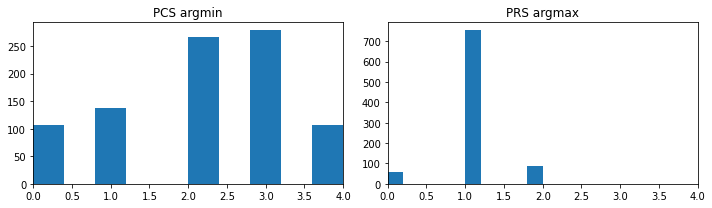

******************** strain p2p ********************


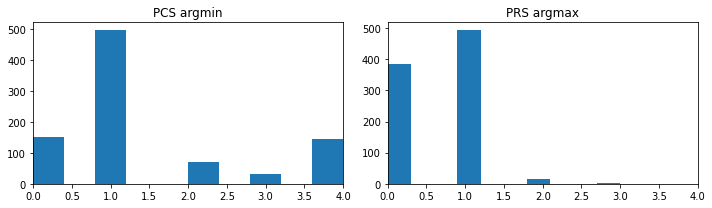

In [13]:
def show_phase_with_max_min_strain(df):
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    # peak radial strain
    rs = np.stack(df.groupby(['pat','aha'])['our_rs'].apply(list).values).astype(np.float32)
    # peak circumferential strain
    cs = np.stack(df.groupby(['pat','aha'])['our_cs'].apply(list).values).astype(np.float32)

    prs_argmax = np.argmax(rs, axis=1)
    pcs_argmin = np.argmin(cs, axis=1)

    # plot
    ax[0].hist(pcs_argmin)
    ax[0].set_title('PCS argmin')
    ax[0].set_xlim(0,4)
    ax[1].hist(prs_argmax)
    ax[1].set_title('PRS argmax')
    ax[1].set_xlim(0,4)
    plt.tight_layout()
    plt.show()
    
print('*'*20,'strain composed','*'*20)
show_phase_with_max_min_strain(df_strain_comp)
print('*'*20,'strain p2p','*'*20)
show_phase_with_max_min_strain(df_strain_p2p)

# Pairplot

## Composed Strain

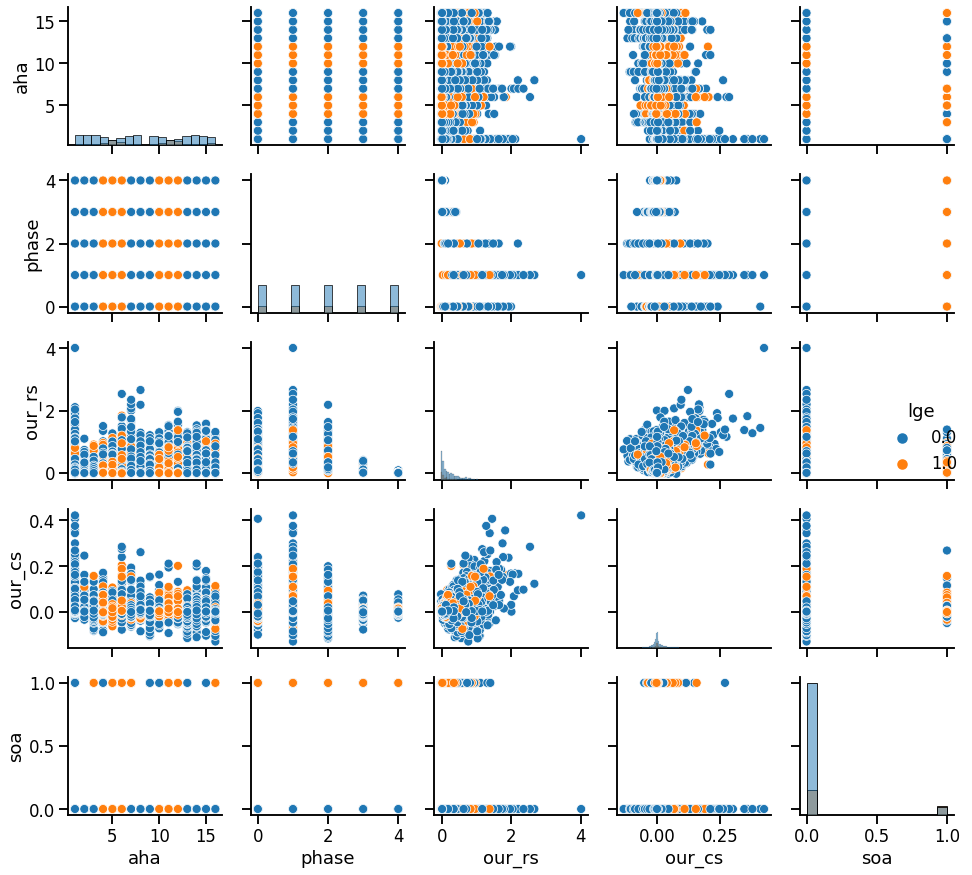

In [14]:
sb.set_context("talk")
g = sb.pairplot(data=df_strain_comp,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

## p2p Strain

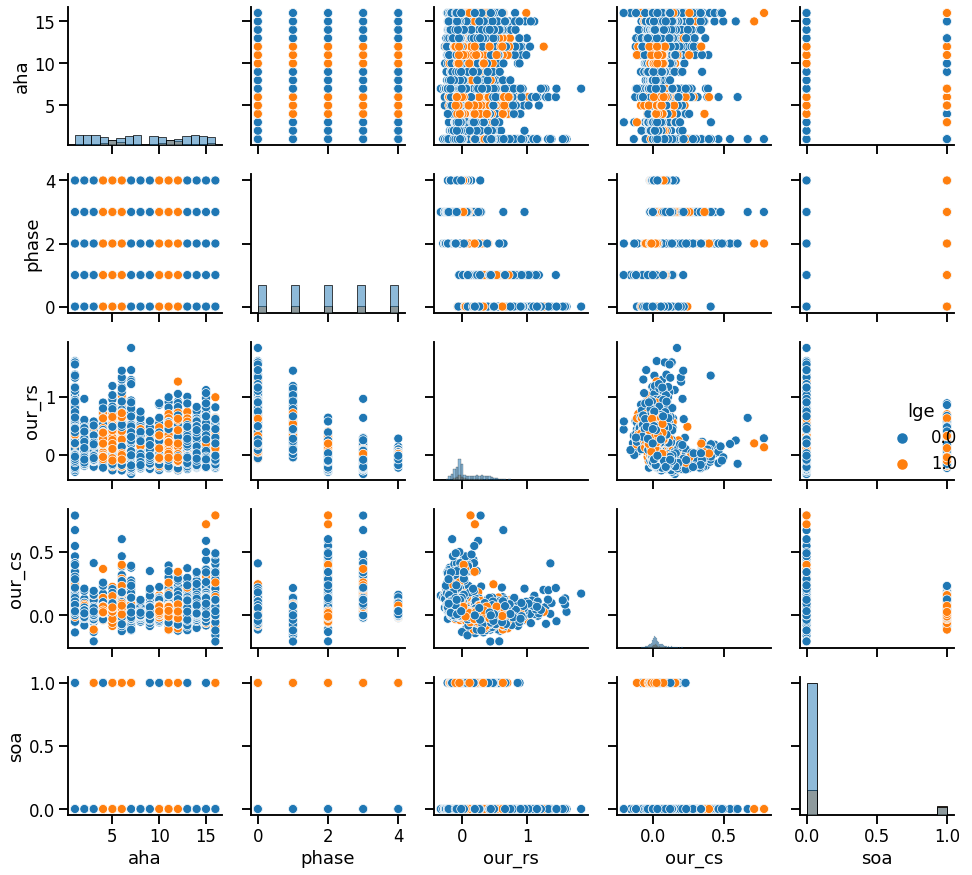

In [15]:
sb.set_context("talk")
g = sb.pairplot(data=df_strain_p2p,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

## Peak Strain

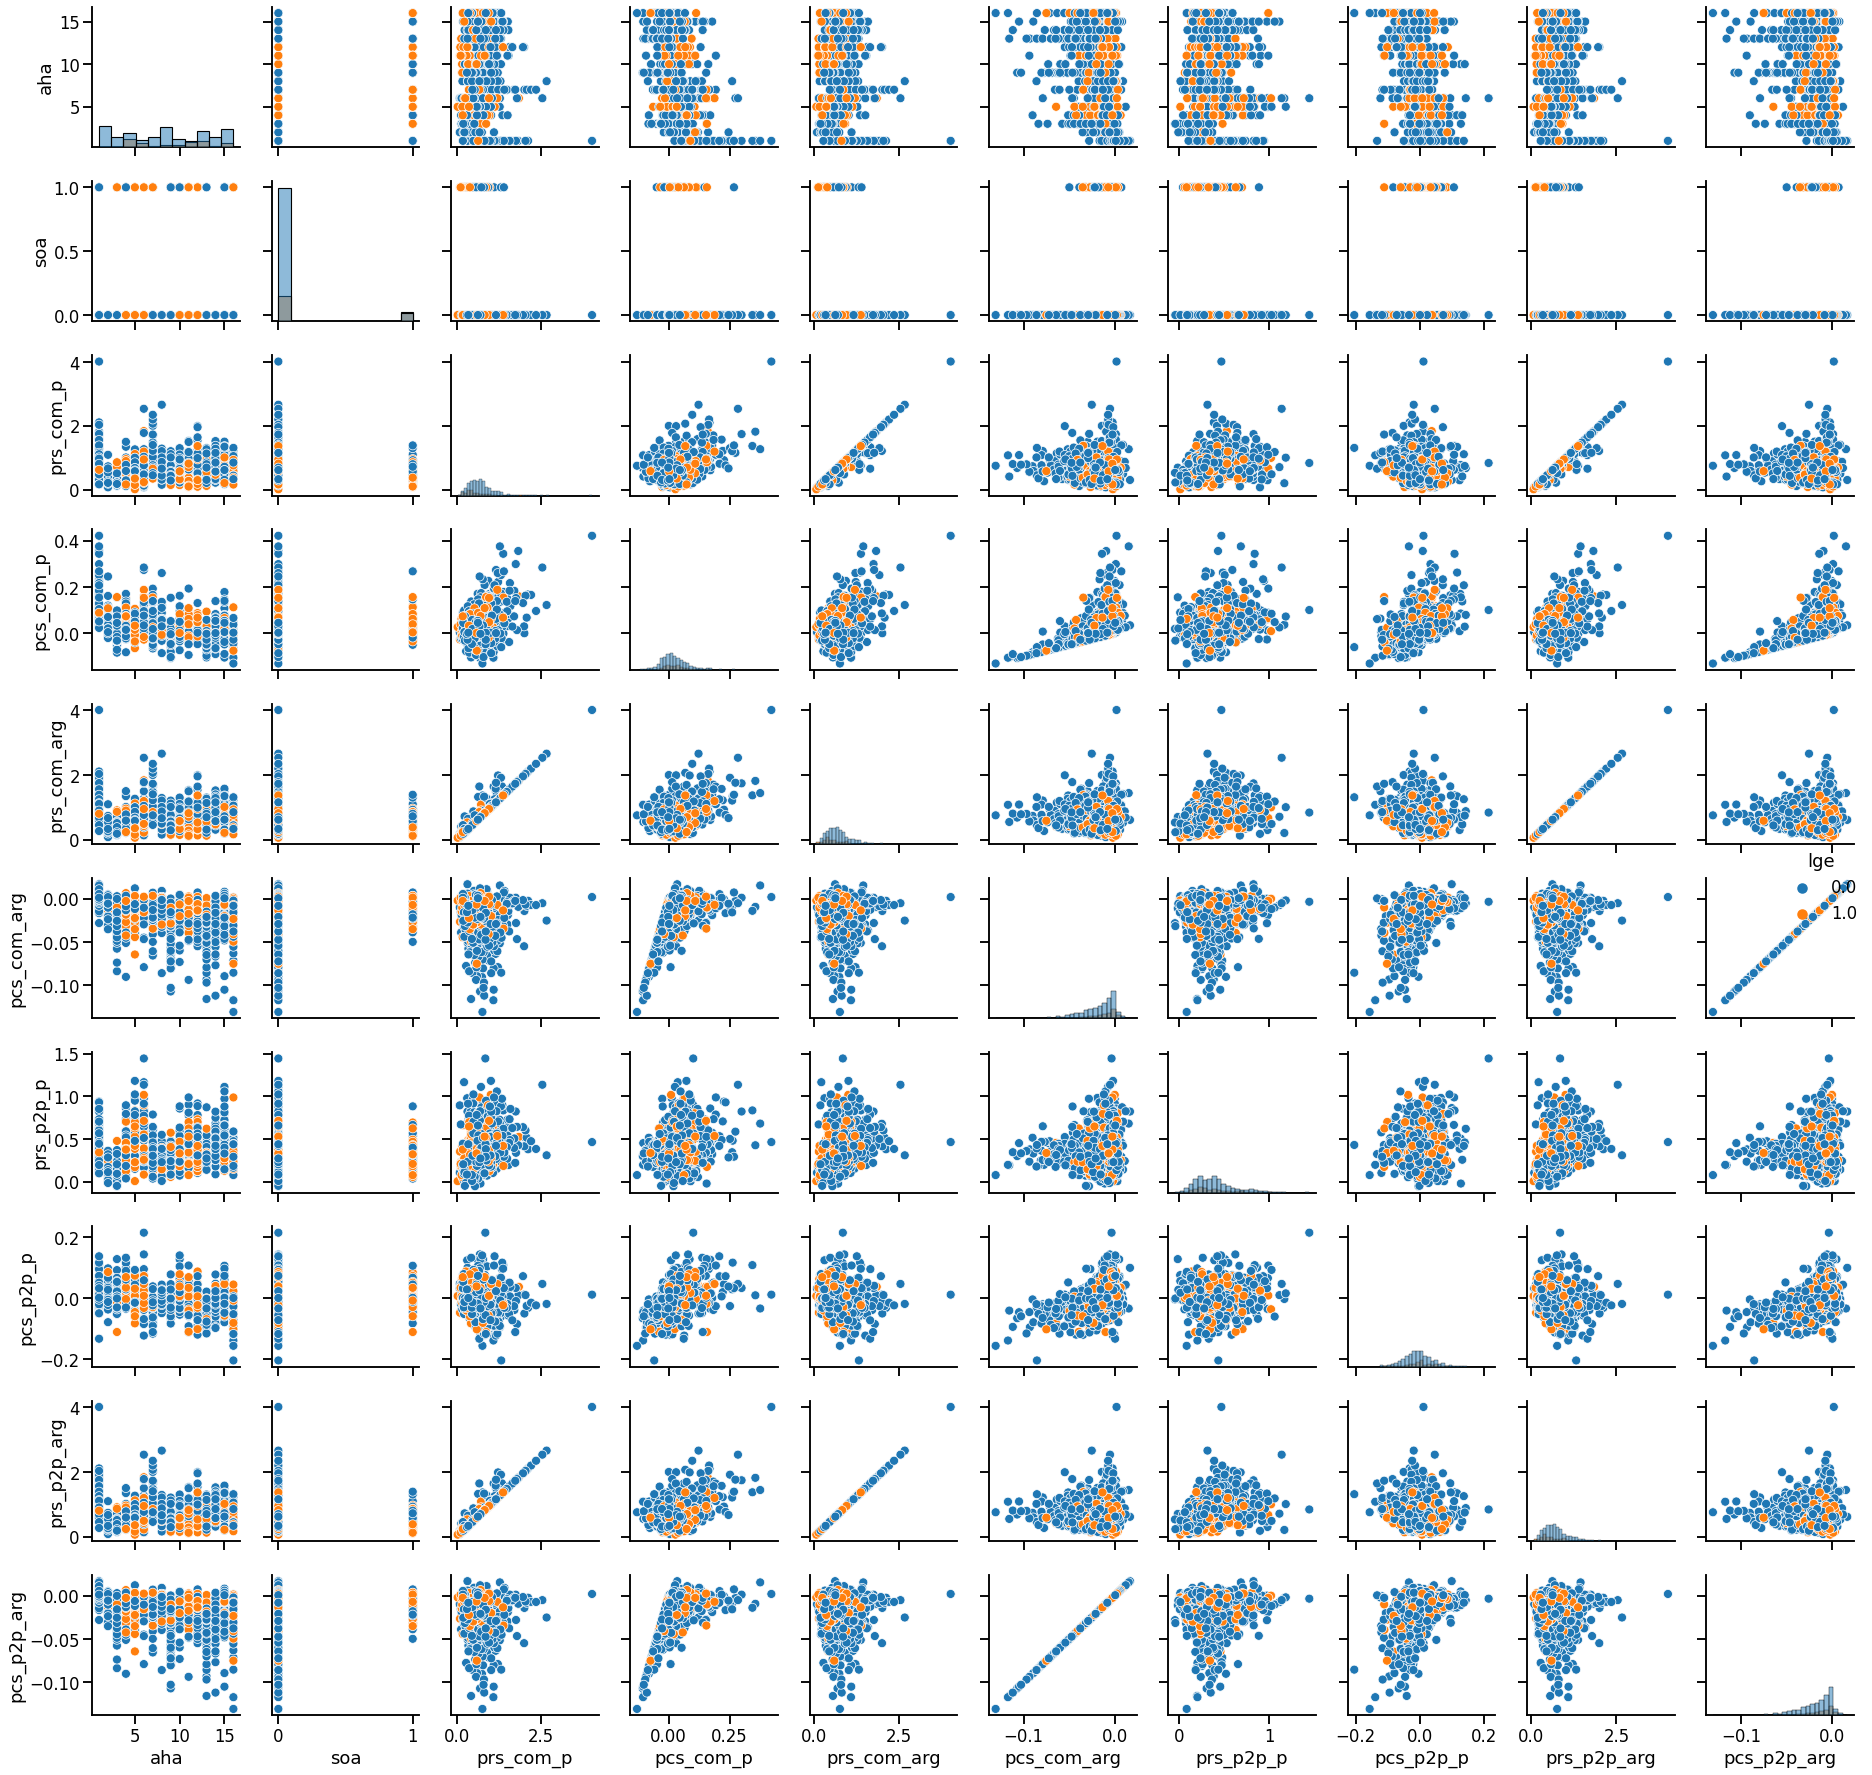

In [16]:
sb.set_context("talk")
g = sb.pairplot(data=df_peak,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

# Correlation plots

## Composed Strain

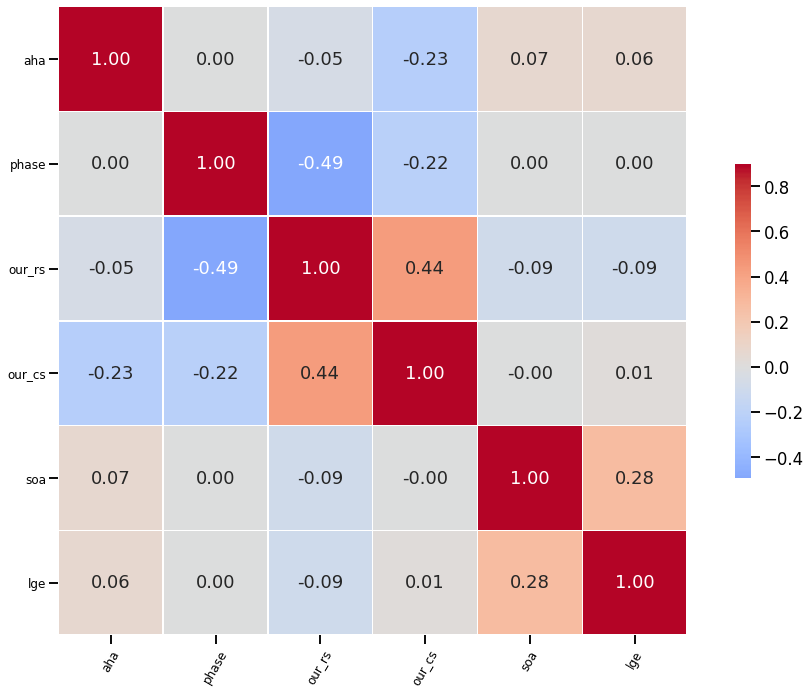

In [17]:
fig, ax = plt.subplots(figsize=(14,10)) 
corr = df_strain_comp.corr(method='pearson')
g = sb.heatmap(corr,  vmax=.9, center=0,ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
_ = g.set_xticklabels(g.get_xticklabels(), rotation = 60, fontsize = 12)
plt.tight_layout()
#fig.savefig('strain_corr_cvi_vs_ours.png')

## p2p Strain

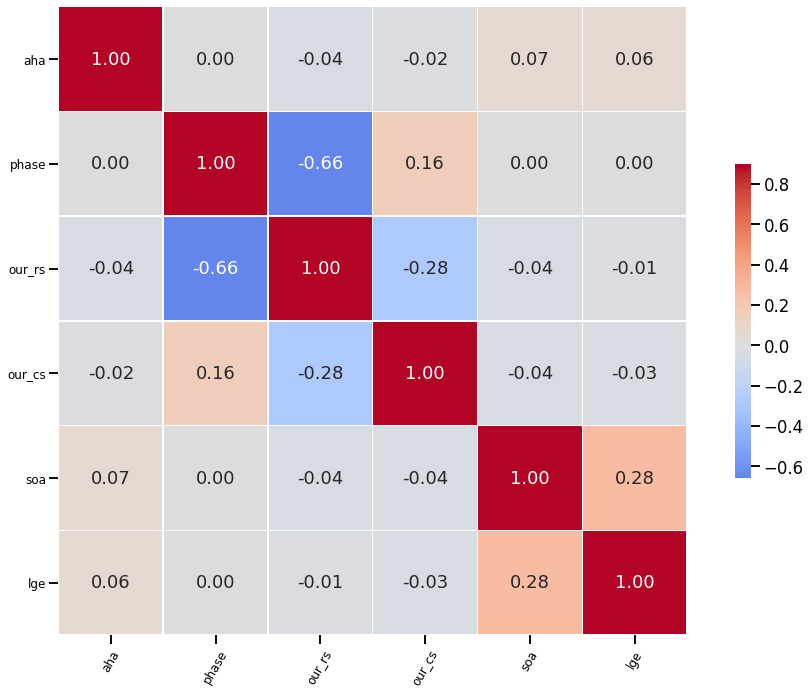

In [18]:
fig, ax = plt.subplots(figsize=(14,10)) 
corr = df_strain_p2p.corr(method='pearson')
g = sb.heatmap(corr,  vmax=.9, center=0,ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
_ = g.set_xticklabels(g.get_xticklabels(), rotation = 60, fontsize = 12)
plt.tight_layout()

## Peak Strain

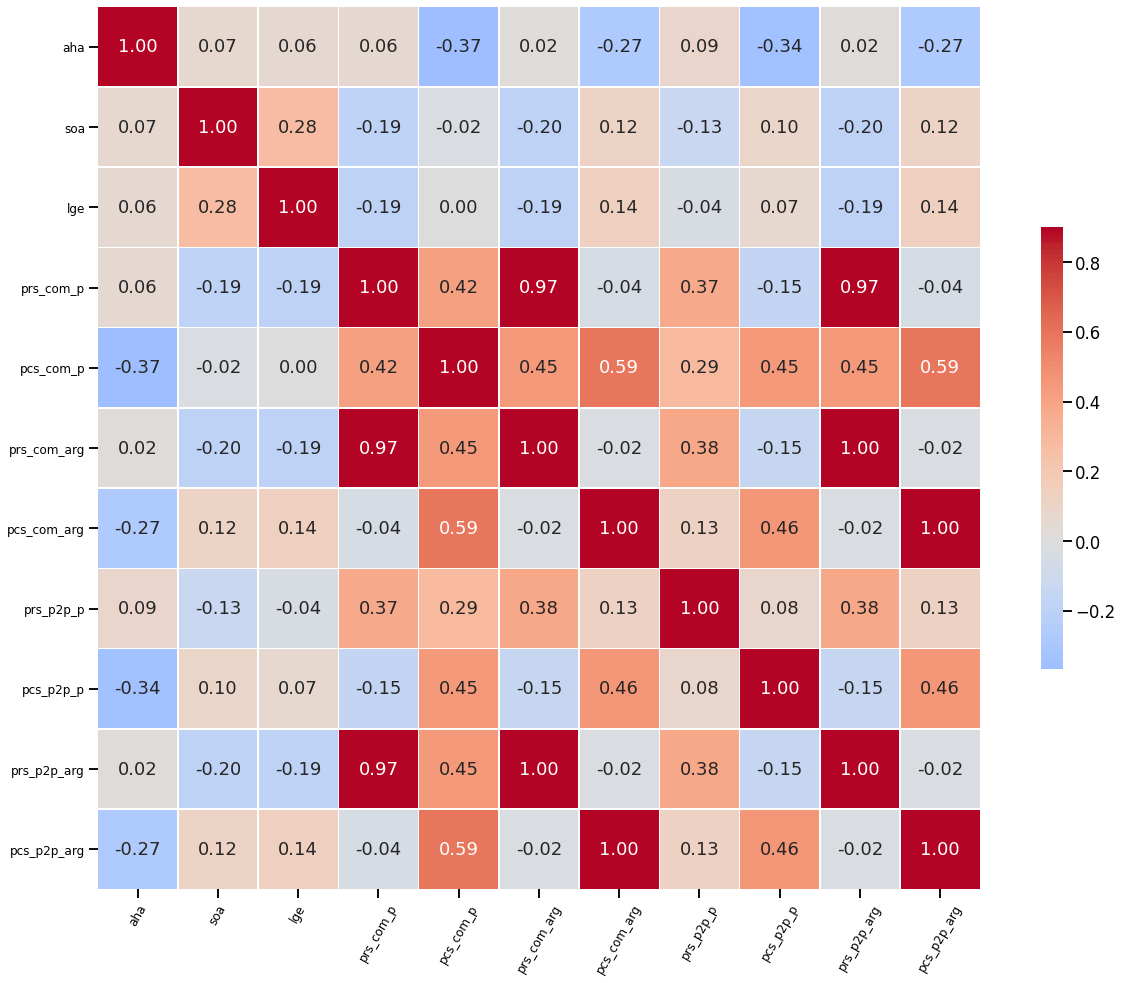

In [19]:
fig, ax = plt.subplots(figsize=(18,14)) 
corr = df_peak.corr(method='pearson')
g = sb.heatmap(corr,  vmax=.9, center=0,ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
_ = g.set_xticklabels(g.get_xticklabels(), rotation = 60, fontsize = 12)
plt.tight_layout()

# Strain per phase

Extract one feature Vector per Patient (56 patients times 16 segments times 5 phases times two feature (rs, cs))

- 32 LGE positive patients
- 24 LGE negative patients

## Strain per patient from composed df (56 x 16 x 5 x 2) --> 56, 160

(56, 80)
(56, 160)
(56, 80)
(56,)
********** Logistic Regression **********
[0.71428571 0.83333333 0.83333333 0.66666667 0.71428571]
Recall: 0.75 (+/- 0.07) [Logistic Regression]
Accuracy: 0.65 (+/- 0.15) [Logistic Regression]
********** Random Forest **********
[0.71428571 1.         0.66666667 0.33333333 0.85714286]
Recall: 0.71 (+/- 0.22) [Random Forest]
Accuracy: 0.54 (+/- 0.18) [Random Forest]
********** naive Bayes **********
[0.57142857 0.33333333 0.83333333 0.33333333 0.42857143]
Recall: 0.50 (+/- 0.19) [naive Bayes]
Accuracy: 0.50 (+/- 0.13) [naive Bayes]
********** scaled DecissionTree **********
[0.42857143 0.83333333 0.83333333 0.16666667 0.71428571]
Recall: 0.60 (+/- 0.26) [scaled DecissionTree]
Accuracy: 0.52 (+/- 0.21) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.16666667 0.66666667 0.33333333 0.42857143]
Recall: 0.43 (+/- 0.18) [KNN]
Accuracy: 0.37 (+/- 0.13) [KNN]
********** scaled SVC(poly) **********
[1.         1.         0.66666667 1.         1.  

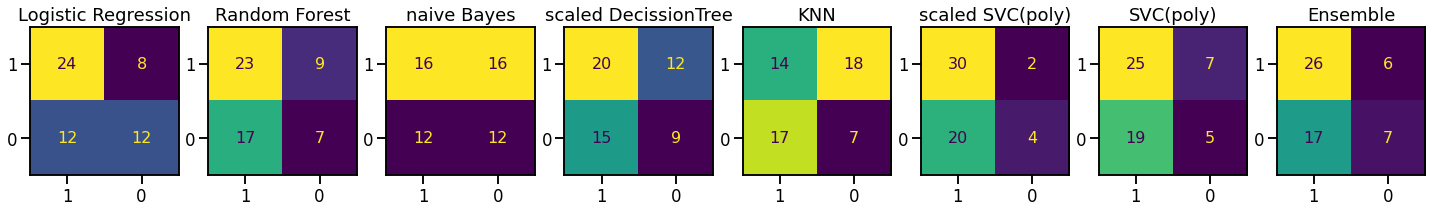

In [20]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_strain_comp.groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_comp.groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_strain_comp.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain per patient from p2p df (56 x 16 x 5 x 2) --> 56, 160

(57, 80)
(57, 160)
(57, 80)
(57,)
********** Logistic Regression **********
[0.71428571 0.28571429 0.83333333 0.5        0.57142857]
Recall: 0.58 (+/- 0.19) [Logistic Regression]
Accuracy: 0.55 (+/- 0.08) [Logistic Regression]
********** Random Forest **********
[0.71428571 1.         1.         0.5        0.85714286]
Recall: 0.81 (+/- 0.19) [Random Forest]
Accuracy: 0.62 (+/- 0.12) [Random Forest]
********** naive Bayes **********
[0.57142857 0.42857143 0.66666667 0.5        0.57142857]
Recall: 0.55 (+/- 0.08) [naive Bayes]
Accuracy: 0.57 (+/- 0.09) [naive Bayes]
********** scaled DecissionTree **********
[0.71428571 1.         0.83333333 0.66666667 0.57142857]
Recall: 0.76 (+/- 0.15) [scaled DecissionTree]
Accuracy: 0.65 (+/- 0.01) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.42857143 0.66666667 0.16666667 0.57142857]
Recall: 0.48 (+/- 0.17) [KNN]
Accuracy: 0.46 (+/- 0.15) [KNN]
********** scaled SVC(poly) **********
[0.85714286 1.         1.         1.         1.  

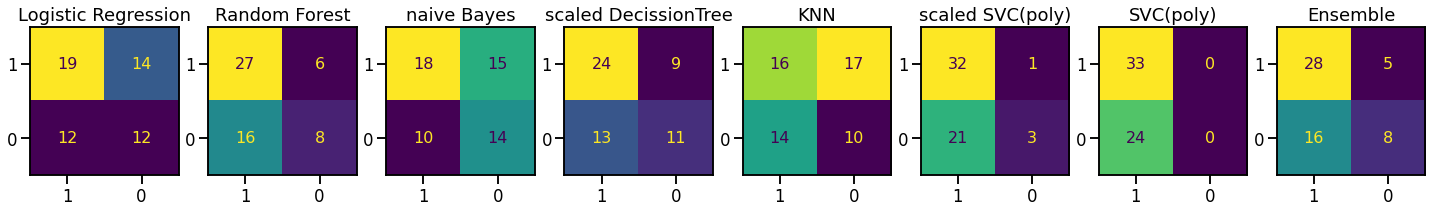

In [15]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_strain_p2p.groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_p2p.groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_strain_p2p.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain per patient from p2p & composed df (56 x 16 x 5 x 2 x 2) --> 56, 320

# Peak Strain

- p2p
cs x 16 segments x 5 phases (80) & rs x 16 segments x 5 phases (80) --> 160 features per patient

- ed2p
cs x 16 segments x 5 phases (80) & rs x 16 segments x 5 phases (80) --> 160 features per patient

--> 320 features per patient

(57, 80)
(57, 320)
(57, 80)
(57,)
********** Logistic Regression **********
[0.85714286 0.42857143 1.         0.5        0.57142857]
Recall: 0.67 (+/- 0.22) [Logistic Regression]
Accuracy: 0.62 (+/- 0.08) [Logistic Regression]
********** Random Forest **********
[0.85714286 1.         1.         0.83333333 0.71428571]
Recall: 0.88 (+/- 0.11) [Random Forest]
Accuracy: 0.67 (+/- 0.08) [Random Forest]
********** naive Bayes **********
[0.57142857 0.42857143 0.66666667 0.5        0.57142857]
Recall: 0.55 (+/- 0.08) [naive Bayes]
Accuracy: 0.51 (+/- 0.08) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 1.         0.83333333 0.33333333 0.85714286]
Recall: 0.72 (+/- 0.24) [scaled DecissionTree]
Accuracy: 0.65 (+/- 0.08) [scaled DecissionTree]
********** KNN **********
[0.42857143 0.57142857 0.33333333 0.33333333 0.57142857]
Recall: 0.45 (+/- 0.11) [KNN]
Accuracy: 0.47 (+/- 0.14) [KNN]
********** scaled SVC(poly) **********
[1. 1. 1. 1. 1.]
Recall: 1.00 (+/- 0.00) [scaled 

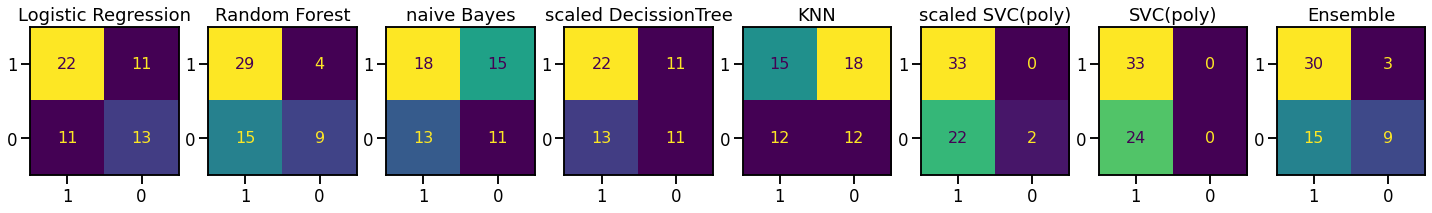

In [16]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_strain_comp.groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_comp.groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc_p = np.stack(df_strain_p2p.groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr_p = np.stack(df_strain_p2p.groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr, xc_p, xr_p], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_strain_p2p.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## (BEST) Strain (Phase) per patient from composed df

(57, 16)
(57, 32)
(57, 16)
(57,)
********** Logistic Regression **********
[0.71428571 0.42857143 0.83333333 0.66666667 0.71428571]
Recall: 0.67 (+/- 0.13) [Logistic Regression]
Accuracy: 0.65 (+/- 0.10) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.85714286 0.66666667 0.66666667 1.        ]
Recall: 0.78 (+/- 0.13) [Random Forest]
Accuracy: 0.61 (+/- 0.11) [Random Forest]
********** naive Bayes **********
[0.71428571 0.85714286 0.66666667 0.66666667 1.        ]
Recall: 0.78 (+/- 0.13) [naive Bayes]
Accuracy: 0.72 (+/- 0.17) [naive Bayes]
********** scaled DecissionTree **********
[0.85714286 1.         0.66666667 0.5        0.42857143]
Recall: 0.69 (+/- 0.21) [scaled DecissionTree]
Accuracy: 0.56 (+/- 0.10) [scaled DecissionTree]
********** KNN **********
[0.71428571 0.42857143 0.66666667 0.66666667 0.57142857]
Recall: 0.61 (+/- 0.10) [KNN]
Accuracy: 0.65 (+/- 0.09) [KNN]
********** scaled SVC(poly) **********
[0.85714286 1.         1.         1.         0.571

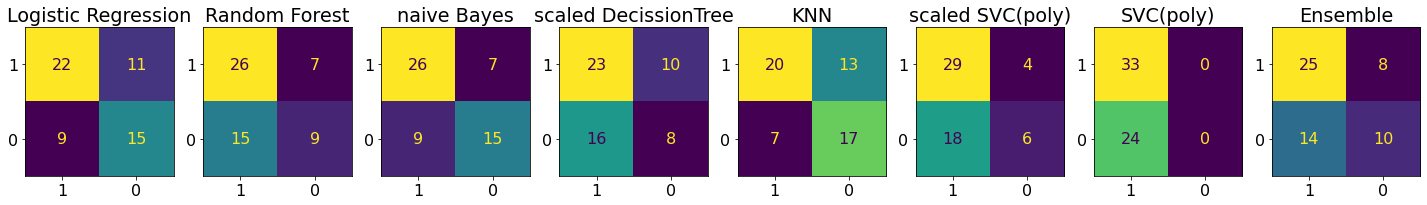

In [9]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.groupby(['pat'])['pcs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.groupby(['pat'])['prs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain (arg-min/max) per patient from composed df

(57, 16)
(57, 32)
(57, 16)
(57,)
********** Logistic Regression **********
[0.85714286 0.57142857 0.83333333 0.66666667 0.57142857]
Recall: 0.70 (+/- 0.12) [Logistic Regression]
Accuracy: 0.65 (+/- 0.06) [Logistic Regression]
********** Random Forest **********
[1.         0.57142857 0.83333333 1.         0.42857143]
Recall: 0.77 (+/- 0.23) [Random Forest]
Accuracy: 0.58 (+/- 0.11) [Random Forest]
********** naive Bayes **********
[0.71428571 0.57142857 0.83333333 0.5        0.42857143]
Recall: 0.61 (+/- 0.15) [naive Bayes]
Accuracy: 0.53 (+/- 0.04) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 1.         0.5        0.83333333 0.14285714]
Recall: 0.61 (+/- 0.29) [scaled DecissionTree]
Accuracy: 0.54 (+/- 0.13) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.71428571 0.83333333 0.5        0.57142857]
Recall: 0.64 (+/- 0.12) [KNN]
Accuracy: 0.58 (+/- 0.03) [KNN]
********** scaled SVC(poly) **********
[0.71428571 0.71428571 1.         1.         0.428

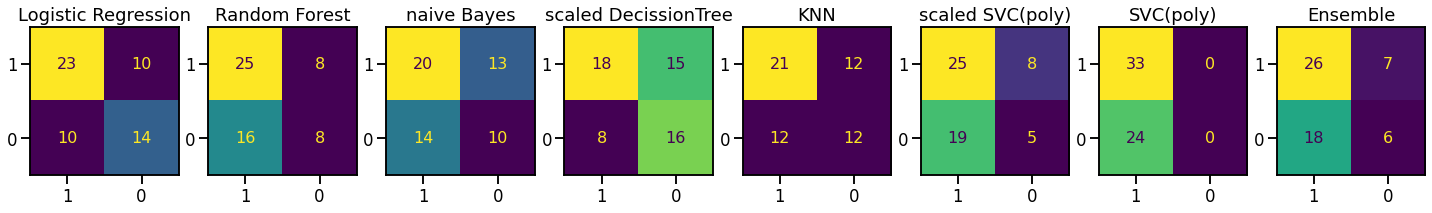

In [18]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.groupby(['pat'])['pcs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.groupby(['pat'])['prs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain (Phase) per patient from p2p df

(57, 16)
(57, 32)
(57, 16)
(57,)
********** Logistic Regression **********
[0.57142857 0.14285714 0.83333333 0.5        0.42857143]
Recall: 0.50 (+/- 0.22) [Logistic Regression]
Accuracy: 0.51 (+/- 0.11) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.57142857 0.83333333 0.66666667 0.57142857]
Recall: 0.64 (+/- 0.10) [Random Forest]
Accuracy: 0.47 (+/- 0.04) [Random Forest]
********** naive Bayes **********
[0.71428571 0.14285714 0.83333333 0.83333333 0.57142857]
Recall: 0.62 (+/- 0.26) [naive Bayes]
Accuracy: 0.51 (+/- 0.19) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.71428571 0.66666667 0.66666667 0.42857143]
Recall: 0.61 (+/- 0.10) [scaled DecissionTree]
Accuracy: 0.45 (+/- 0.05) [scaled DecissionTree]
********** KNN **********
[0.71428571 0.28571429 0.66666667 0.66666667 0.85714286]
Recall: 0.64 (+/- 0.19) [KNN]
Accuracy: 0.57 (+/- 0.14) [KNN]
********** scaled SVC(poly) **********
[1.         0.85714286 1.         1.         1.   

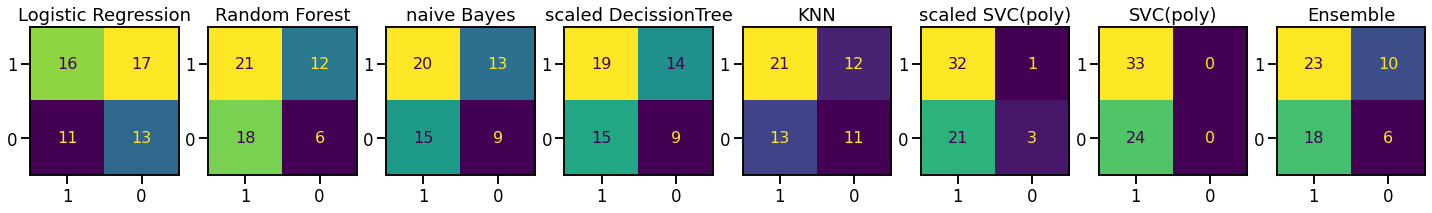

In [19]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.groupby(['pat'])['pcs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.groupby(['pat'])['prs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain (arg-min/max) per patient from p2p df

(57, 16)
(57, 32)
(57, 16)
(57,)
********** Logistic Regression **********
[0.85714286 0.57142857 0.83333333 0.66666667 0.57142857]
Recall: 0.70 (+/- 0.12) [Logistic Regression]
Accuracy: 0.65 (+/- 0.06) [Logistic Regression]
********** Random Forest **********
[1.         0.57142857 0.83333333 1.         0.42857143]
Recall: 0.77 (+/- 0.23) [Random Forest]
Accuracy: 0.58 (+/- 0.11) [Random Forest]
********** naive Bayes **********
[0.71428571 0.57142857 0.83333333 0.5        0.42857143]
Recall: 0.61 (+/- 0.15) [naive Bayes]
Accuracy: 0.53 (+/- 0.04) [naive Bayes]
********** scaled DecissionTree **********
[0.42857143 0.85714286 0.5        1.         0.14285714]
Recall: 0.59 (+/- 0.31) [scaled DecissionTree]
Accuracy: 0.58 (+/- 0.18) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.71428571 0.83333333 0.5        0.57142857]
Recall: 0.64 (+/- 0.12) [KNN]
Accuracy: 0.58 (+/- 0.03) [KNN]
********** scaled SVC(poly) **********
[0.71428571 0.71428571 1.         1.         0.428

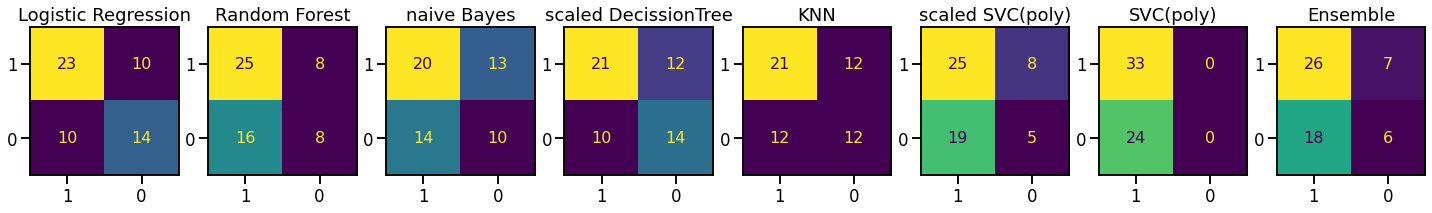

In [20]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.groupby(['pat'])['pcs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.groupby(['pat'])['prs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## (Most robust) Strains concatenatet per patient

(57, 16)
(57, 128)
(57, 16)
(57,)
********** Logistic Regression **********
[0.71428571 0.28571429 0.83333333 0.66666667 0.85714286]
Recall: 0.67 (+/- 0.21) [Logistic Regression]
Accuracy: 0.58 (+/- 0.10) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.71428571 0.66666667 0.66666667 1.        ]
Recall: 0.75 (+/- 0.13) [Random Forest]
Accuracy: 0.67 (+/- 0.15) [Random Forest]
********** naive Bayes **********
[0.71428571 0.57142857 0.66666667 0.66666667 0.85714286]
Recall: 0.70 (+/- 0.09) [naive Bayes]
Accuracy: 0.65 (+/- 0.12) [naive Bayes]
********** scaled DecissionTree **********
[0.71428571 0.28571429 0.66666667 0.83333333 1.        ]
Recall: 0.70 (+/- 0.24) [scaled DecissionTree]
Accuracy: 0.62 (+/- 0.21) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.57142857 0.66666667 0.5        0.85714286]
Recall: 0.63 (+/- 0.12) [KNN]
Accuracy: 0.67 (+/- 0.15) [KNN]
********** scaled SVC(poly) **********
[0.85714286 0.71428571 0.83333333 0.83333333 0.42

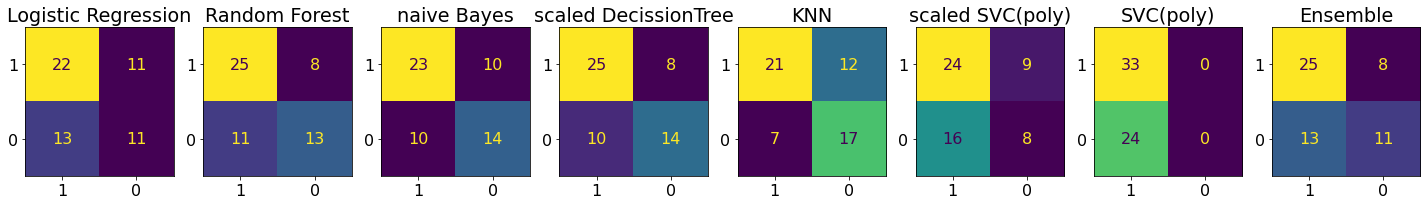

In [10]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.groupby(['pat'])['pcs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.groupby(['pat'])['prs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc2 = np.stack(df_peak.groupby(['pat'])['pcs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr2 = np.stack(df_peak.groupby(['pat'])['prs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc3 = np.stack(df_peak.groupby(['pat'])['pcs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr3 = np.stack(df_peak.groupby(['pat'])['prs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc4 = np.stack(df_peak.groupby(['pat'])['pcs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr4 = np.stack(df_peak.groupby(['pat'])['prs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr,xc2,xr2,xc3,xr3,xc4,xr4], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

# Strain per Segment

In [119]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_strain_comp.groupby(['pat','aha'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_comp.groupby(['pat','aha'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_strain_comp.groupby(['pat','aha'])['lge'].apply(list).values).astype(np.float32)
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
#cross_validate_f1(x,y)

(896, 5)
(896, 10)
(896, 5)
(896,)


In [120]:
# check for nan and infinit values
x[~np.isfinite(x)]

array([], dtype=float32)

# Unsupervised Clustering

In [11]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#temp_2d = TSNE(n_components=2, perplexity=4, learning_rate=50).fit_transform(x)
#temp_2d = PCA(n_components=2).fit_transform(x)
temp_2d = nca = make_pipeline(
    #StandardScaler(),
    MinMaxScaler(),
    #NeighborhoodComponentsAnalysis(n_components=4, random_state=42),
    TSNE(n_components=2, perplexity=2, learning_rate=500, method='exact', init='pca')
    ).fit_transform(x)

/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(57, 3)


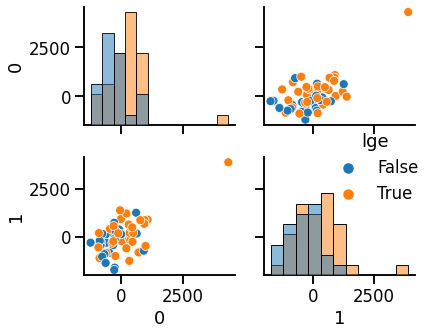

In [12]:
sb.set_context("talk")
df_temp = pd.DataFrame(temp_2d)
df_temp['lge'] = y
print(df_temp.shape)
g = sb.pairplot(data=df_temp,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

In [ ]:
cross_validate_f1(temp_2d,y)

********** Logistic Regression **********
[0.71428571 0.42857143 0.83333333 0.5        1.        ]
Recall: 0.70 (+/- 0.21) [Logistic Regression]
Accuracy: 0.70 (+/- 0.08) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.57142857 0.66666667 0.66666667 0.85714286]
Recall: 0.70 (+/- 0.09) [Random Forest]
Accuracy: 0.63 (+/- 0.12) [Random Forest]
********** naive Bayes **********
[0.42857143 0.57142857 0.83333333 0.5        0.85714286]
Recall: 0.64 (+/- 0.18) [naive Bayes]
Accuracy: 0.69 (+/- 0.08) [naive Bayes]
********** scaled DecissionTree **********
[0.85714286 0.57142857 0.66666667 0.66666667 0.85714286]
Recall: 0.72 (+/- 0.11) [scaled DecissionTree]
Accuracy: 0.65 (+/- 0.10) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.42857143 0.66666667 0.5        0.42857143]
Recall: 0.52 (+/- 0.09) [KNN]
Accuracy: 0.58 (+/- 0.10) [KNN]
********** scaled SVC(poly) **********
[0.85714286 0.57142857 0.66666667 0.66666667 0.71428571]
Recall: 0.70 (+/- 0.09) [s

# Gridsearch for the SVC Estimator pipeline

In [153]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'clf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'clf__C', 'clf__break_ties', 'clf__cache_size', 'clf__class_weight', 'clf__coef0', 'clf__decision_function_shape', 'clf__degree', 'clf__gamma', 'clf__kernel', 'clf__max_iter', 'clf__probability', 'clf__random_state', 'clf__shrinking', 'clf__tol', 'clf__verbose'])

In [37]:

def create_grid_search():
    gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 'scale', 'auto']
    Cs = [0.1, 1, 10, 100, 1e3, 1e4, 1e5]
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    weights = [None, 'balanced']
    degree = [2,3,4,5]
    n_estimators = [10,10,500,1000]

    penalties = ['l2']
    solvers = ['liblinear', 'lbfgs']

    scaler = [StandardScaler(), MinMaxScaler(), None]

    [ 
     'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 
     'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 
     'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 
     'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose']

    svc_params = {'clf':(SVC(),), 
                  'clf__gamma': gammas, 
                  'clf__C': Cs, 
                  'clf__kernel': kernels, 
                  'clf__class_weight':weights,
                 'scaler': scaler}
    rf_params = {'clf':(RandomForestClassifier( random_state=1, class_weight='balanced'),),
                'clf__n_estimators':n_estimators,
                 'clf__class_weight':weights,
                'scaler': scaler}
    lr_params = {'clf':(LogisticRegression(random_state=1, class_weight='balanced'),),
                 'clf__class_weight':weights,
                 'clf__penalty':penalties,
                 'clf__C': Cs,
                 'clf__solver': solvers,
                'scaler': scaler}
    et_params = {'clf': (ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1),),
                 'clf__n_estimators':n_estimators,
                'scaler': scaler}
    params = [rf_params, svc_params, rf_params, et_params]


    pipeline = Pipeline( steps=[
        ('scaler',StandardScaler()), 
        ('clf', SVC())
    ])
    return GridSearchCV(estimator=pipeline, param_grid=params, scoring=['recall', 'accuracy', 'balanced_accuracy', 'average_precision','precision', 'f1'], refit='balanced_accuracy', n_jobs=16)
gs = create_grid_search()
gs = gs.fit(x, y)

In [43]:
results = pd.DataFrame.from_dict(gs.cv_results_)
results["params_str"] = results.params.apply(str)
pd.set_option('display.max_colwidth', None)
results.shape

(1572, 61)

In [44]:
results.sort_values(by=['rank_test_f1','rank_test_accuracy','rank_test_recall'])[['mean_test_f1','mean_test_recall', 'mean_test_accuracy', 'params_str']].head(5)

,mean_test_f1,mean_test_recall,mean_test_accuracy,params_str
147,0.7691,1.0,0.65,"{'clf': SVC(C=10, class_weight='balanced', kernel='sigmoid'), 'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__gamma': 0.01, 'clf__kernel': 'poly', 'scaler': StandardScaler()}"
219,0.7691,1.0,0.65,"{'clf': SVC(C=10, class_weight='balanced', kernel='sigmoid'), 'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'poly', 'scaler': StandardScaler()}"
231,0.7691,1.0,0.65,"{'clf': SVC(C=10, class_weight='balanced', kernel='sigmoid'), 'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__gamma': 'auto', 'clf__kernel': 'poly', 'scaler': StandardScaler()}"
807,0.7691,1.0,0.65,"{'clf': SVC(C=10, class_weight='balanced', kernel='sigmoid'), 'clf__C': 100, 'clf__class_weight': 'balanced', 'clf__gamma': 0.001, 'clf__kernel': 'poly', 'scaler': StandardScaler()}"
1467,0.7691,1.0,0.65,"{'clf': SVC(C=10, class_weight='balanced', kernel='sigmoid'), 'clf__C': 100000.0, 'clf__class_weight': 'balanced', 'clf__gamma': 0.0001, 'clf__kernel': 'poly', 'scaler': StandardScaler()}"


In [45]:
results.sort_values(by=['rank_test_balanced_accuracy', 'rank_test_recall','rank_test_f1'])[['mean_test_recall', 
                                                                        'mean_test_accuracy', 
                                                                        'mean_test_balanced_accuracy', 
                                                                        'mean_test_average_precision',
                                                                        'mean_test_precision', 
                                                                        'mean_test_f1', 
                                                                        'params_str']].head(5)

,mean_test_recall,mean_test_accuracy,mean_test_balanced_accuracy,mean_test_average_precision,mean_test_precision,mean_test_f1,params_str
657,0.647619,0.721212,0.743810,0.845203,0.880952,0.687396,"{'clf': SVC(C=10, class_weight='balanced', kernel='sigmoid'), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'sigmoid', 'scaler': StandardScaler()}"
669,0.647619,0.721212,0.743810,0.845203,0.880952,0.687396,"{'clf': SVC(C=10, class_weight='balanced', kernel='sigmoid'), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 'auto', 'clf__kernel': 'sigmoid', 'scaler': StandardScaler()}"
884,0.700000,0.716667,0.730000,0.865993,0.838095,0.743290,"{'clf': SVC(C=10, class_weight='balanced', kernel='sigmoid'), 'clf__C': 100, 'clf__class_weight': 'balanced', 'clf__gamma': 'auto', 'clf__kernel': 'rbf', 'scaler': None}"
1256,0.733333,0.719697,0.726667,0.824875,0.799206,0.747186,"{'clf': SVC(C=10, class_weight='balanced', kernel='sigmoid'), 'clf__C': 10000.0, 'clf__class_weight': 'balanced', 'clf__gamma': 0.0001, 'clf__kernel': 'rbf', 'scaler': None}"
1484,0.733333,0.719697,0.726667,0.824875,0.799206,0.747186,"{'clf': SVC(C=10, class_weight='balanced', kernel='sigmoid'), 'clf__C': 100000.0, 'clf__class_weight': 'balanced', 'clf__gamma': 1e-05, 'clf__kernel': 'rbf', 'scaler': None}"


## Evaluate best estimators from gridsearch CV

**Recall** in this context is also referred to as the true positive rate or sensitivity, and 

$\frac{tp}{tp+fn}$ 



**Precision** is also referred to as positive predictive value (PPV); other related measures used in classification include true negative rate and accuracy. True negative rate is also called specificity.

$\frac{tp}{tp+fp)}$



**Accuracy** (maybe missleading for imbalanced data.)

$\frac{tp+tn}{tp+tn+fp+fn}$



params: {'clf': SVC(C=10, class_weight='balanced', kernel='sigmoid'), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'sigmoid', 'scaler': StandardScaler()}
[0.85714286 0.14285714 0.83333333 0.83333333 0.57142857]
Recall: 0.65 (+/- 0.27) []
Accuracy: 0.72 (+/- 0.12) []
Precision: 0.88 (+/- 0.11) []
Balanced Accuracy: 0.74 (+/- 0.09) []
F1: 0.69 (+/- 0.22) []


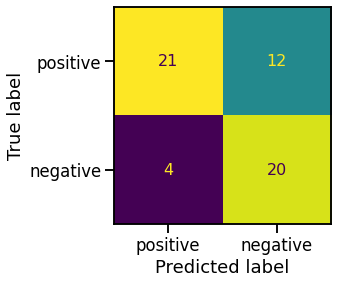

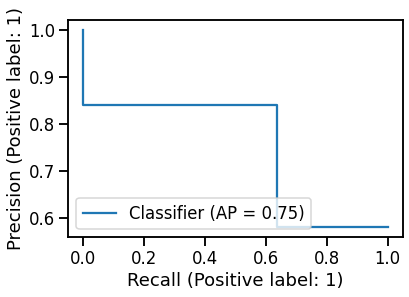

In [46]:
def plot_report(clf, x, y, label=''):
    from sklearn.metrics import (precision_recall_curve,
                                 PrecisionRecallDisplay)
    y_pred = cross_val_predict(clf, x, y, cv=5)
    scores = cross_validate(clf, x, y, scoring=['recall', 'accuracy', 'balanced_accuracy', 'precision', 'f1'], cv=5)
    print('params: {}'.format(label))
    print(scores['test_recall'])
    print("Recall: %0.2f (+/- %0.2f) [%s]" % (scores['test_recall'].mean(), scores['test_recall'].std(), ""))
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std(), ""))
    print("Precision: %0.2f (+/- %0.2f) [%s]" % (scores['test_precision'].mean(), scores['test_precision'].std(), ""))
    print("Balanced Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores['test_balanced_accuracy'].mean(), scores['test_balanced_accuracy'].std(), ""))
    print("F1: %0.2f (+/- %0.2f) [%s]" % (scores['test_f1'].mean(), scores['test_f1'].std(), ""))
    disp = ConfusionMatrixDisplay.from_predictions(y, y_pred,labels=[1,0], display_labels=['positive','negative'],colorbar=False)
    disp = PrecisionRecallDisplay.from_predictions(y,y_pred)
    
plot_report(gs.best_estimator_, x, y, label=gs.best_params_)

In [98]:
print(gs.best_params_)
best_clf

{'clf': SVC(C=10, class_weight='balanced', gamma=0.01), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 0.01, 'clf__kernel': 'rbf', 'scaler': None}


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, class_weight='balanced', kernel='linear'))])

params: [('scaler', StandardScaler()), ('clf', SVC(C=0.1, class_weight='balanced', gamma=0.01, kernel='sigmoid'))]
[1.         0.85714286 1.         1.         0.85714286]
Recall: 0.94 (+/- 0.07) []
Accuracy: 0.65 (+/- 0.06) []
Precision: 0.64 (+/- 0.07) []
Balanced Accuracy: 0.60 (+/- 0.06) []
F1: 0.76 (+/- 0.03) []


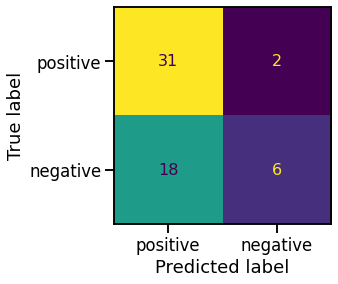

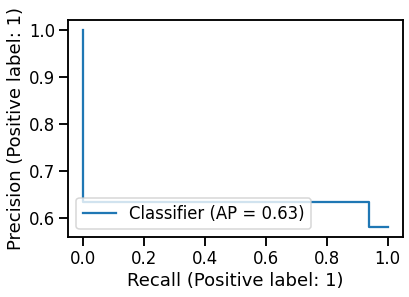

In [47]:
# Best pipeline according to the balanced accuracy
#{'clf': SVC(C=0.1, class_weight='balanced', gamma=0.01, kernel='sigmoid'), 'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__gamma': 0.01, 'clf__kernel': 'sigmoid', 'scaler': StandardScaler()}
best_clf = Pipeline(steps=[('scaler',StandardScaler(),),('clf',SVC(C=0.1, class_weight='balanced', gamma=0.01, kernel='sigmoid'),)])
plot_report(best_clf, x, y, label=best_clf.get_params()['steps'])

params: [('scaler', StandardScaler()), ('clf', SVC(C=10, gamma=0.01, kernel='poly'))]
[0.85714286 0.71428571 1.         1.         1.        ]
Recall: 0.91 (+/- 0.11) []
Accuracy: 0.60 (+/- 0.12) []
Precision: 0.60 (+/- 0.09) []
Balanced Accuracy: 0.55 (+/- 0.12) []
F1: 0.72 (+/- 0.09) []


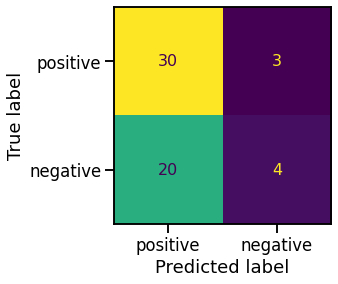

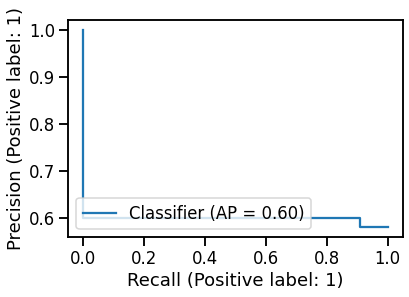

In [48]:
# this one has the highest recall == 1, but no real information gain
best_clf = Pipeline(steps=[('scaler',StandardScaler(),),('clf',SVC(C=10, class_weight=None, gamma=0.01, kernel='poly'),)])
plot_report(best_clf, x, y, label=best_clf.get_params()['steps'])

params: [('standardscaler', StandardScaler()), ('svc', SVC(C=1, class_weight='balanced', kernel='linear'))]
[0.71428571 0.57142857 0.5        0.66666667 0.57142857]
Recall: 0.60 (+/- 0.08) []
Accuracy: 0.49 (+/- 0.12) []
Precision: 0.57 (+/- 0.14) []
Balanced Accuracy: 0.48 (+/- 0.14) []
F1: 0.58 (+/- 0.09) []


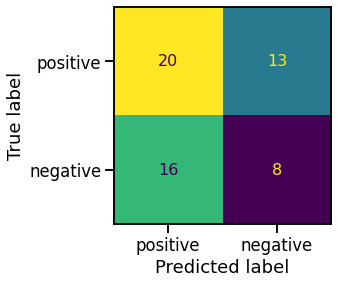

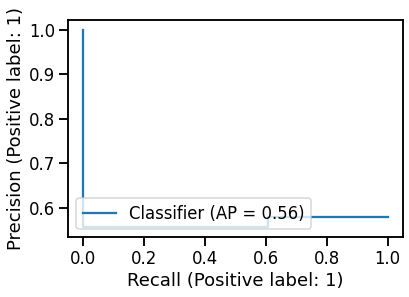

In [49]:
# this one has a high recall, but still a valid accuracy
best_clf = make_pipeline(StandardScaler(), SVC(kernel='linear',gamma='scale',class_weight='balanced', C=1, degree=3))
plot_report(best_clf, x, y, label=best_clf.get_params()['steps'])

params: [('standardscaler', StandardScaler()), ('svc', SVC(C=1, class_weight='balanced', kernel='linear'))]
[0.71428571 0.57142857 0.5        0.66666667 0.57142857]
Recall: 0.60 (+/- 0.08) []
Accuracy: 0.49 (+/- 0.12) []
Precision: 0.57 (+/- 0.14) []
Balanced Accuracy: 0.48 (+/- 0.14) []
F1: 0.58 (+/- 0.09) []


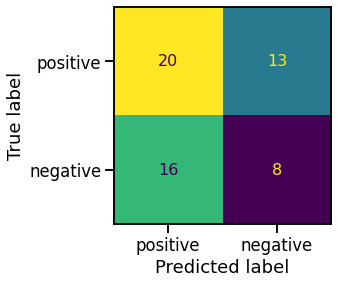

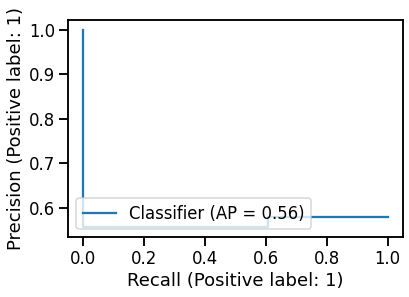

In [50]:
plot_report(best_clf, x, y, label=best_clf.get_params()['steps'])

# Model Essemble according to different metrics

In [51]:
# best balanced accuracy
results.sort_values(by='rank_test_balanced_accuracy', inplace=True, ascending=True)
params_best_ba = results.head(1)['params'].values[0]
print(params_best_ba)
clf_best_ba = gs.best_estimator_.set_params(**params_best_ba)

{'clf': SVC(C=10, class_weight='balanced', kernel='sigmoid'), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'sigmoid', 'scaler': StandardScaler()}


In [52]:
# best f1
results.sort_values(by='rank_test_f1', inplace=True,ascending=True)
params_best_f1 = results.head(1)['params'].values[0]
print(params_best_f1)
clf_best_f1 = gs.best_estimator_.set_params(**params_best_f1)

{'clf': SVC(C=10, class_weight='balanced', kernel='sigmoid'), 'clf__C': 100, 'clf__class_weight': 'balanced', 'clf__gamma': 0.001, 'clf__kernel': 'poly', 'scaler': StandardScaler()}


In [53]:
# best average precision
results.sort_values(by='rank_test_precision', inplace=True,ascending=True)
params_best_ap = results.head(1)['params'].values[0]
print(params_best_ap)
clf_best_ap = gs.best_estimator_.set_params(**params_best_ap)

{'clf': SVC(C=100, class_weight='balanced', gamma=0.001, kernel='poly'), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 'auto', 'clf__kernel': 'sigmoid', 'scaler': StandardScaler()}


In [54]:
eclf = VotingClassifier(
        estimators=[
            ('ba', clf_best_ba), 
            ('f1', clf_best_f1),
            ('ap', clf_best_ap)
                   ],
        voting='hard')

params: ensamble
[0.85714286 0.14285714 0.83333333 0.83333333 0.57142857]
Recall: 0.65 (+/- 0.27) []
Accuracy: 0.72 (+/- 0.12) []
Precision: 0.88 (+/- 0.11) []
Balanced Accuracy: 0.74 (+/- 0.09) []
F1: 0.69 (+/- 0.22) []


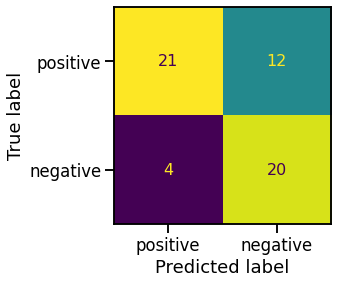

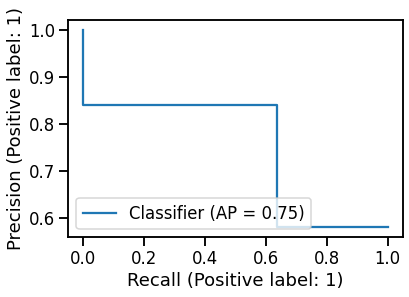

In [55]:
plot_report(eclf, x, y, label='ensamble')